# Explanation Summary

## Results

This notebook is the version 6 which got 1st place in the competition. The ranking surprised me.  
I tried here to explain what I did which could have improved my score.

The submission result are the following:

| output name | private score | public score |
| :--- | ----: | ---: |
| *lgb*      | **0.57703** | 0.60155 |
| *lgb_raw*   | **0.57820** | 0.60516 |
| *stacked* | 0.50466 | 0.50750 |
| *sklearn* | 0.50590 | 0.51066 |

The stacking of *lgb_raw*, *lgb* and *sklearn* with LR did not work as intended.  
On V7 I tried to add the missing indicators but it did not change the score. I kept here below the V6 version without missing indicators.

I had expected the *lgb* file to get the better private score. It is still high enough to achieve 1st place too.


## Solution specificity

I share what I found specific to my solution which could explain the score. (On top of the fact that I avoided the overfit with an unique model).  
I had already worked with Spotify audio feature for a personal project.  
(documentation here: https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features).

### 1. Data Scaling
**This transformation did not improve the public score compare to raw data.**

[Link to specific code paragraph](#scaling)

As usual for me, I do a qq-plot. From the plots, I proposed to scale the data as follows:
```
col_sig = ['acousticness', 'danceability', 'energy', 'instrumentalness',
           'liveness', 'speechiness', 'audio_valence']
col_pow = ['song_duration_ms', 'tempo']
```

The `col_sig` will get an inverse sigmoid transformation. I take as an hypothesis that they're the results of a NN and a sigmoid. With the inverse sigmoid I get the logits values.  
I remember that the usual Spotify values from the API are always between 0 and 1, hence my hypothesis. Some values are outisde (0, 1), so I forced with the min-max scale because the data was maybe transformed for this competition.  

The `col_sig` and the `col_pow` columns goes through `PowerTransform` for a Box-Cox transformation.

The `loudness` column is scaled by `lambda x: np.log1p(-x)`

The function created in this codeblock was to test the output on qq-plots.  
The transformation used for the LGB models is done with sklearn `Pipeline` and `ColumnTransfomer` to avoid data leakage. See `transformer` in the following code-block: [sklearn pipeline](#sklearn)


### 2. Data Splitting <-- probably what helped the most

[Link to specific code paragraph](#split)

I created 2 cv folds:
* train/valid/test to as usual work on train/valid but evaluate on test if necessary after CV optimization.
* train/valid with all the data for the final training. I only used this one for the LGB best solution (did not want to wait for 2 training)

**I stratified the data on categorical columns, missing values, and target labels.**

categorical columns : `audio_mode`, `time_signature`  
missing values : `MissingIndicator` with an `any()` aggregation. So I would be sure to get the same **10%** of missing values in each folds.

The categorical columns because they're quite important to a song.  
The missing values because they are artificial, so it must be the competition focus. I wanted my model to generalize well with those missing features.


### 3. Models

#### 3.1 [GridSearchCV - benchmark for feature transformation](#sklearn)
The sklearn `GridSearchCV` benchmark my proposed feature transformation and which imputer was best between `SimpleImputer(strategy='median')`, `SimpleImputer(strategy='mean')`, `IterativeImputer()`.
`IterativeImputer` was best but not used with LGB.

#### 3.2 [Optimized LightGBM with Optuna `LightGBMTunerCV`](#lgb)

`LightGBMTunerCV`:
It is a serial optimization (instead to try all combination, you find best for one parameter and optimized next parameter). It could be used as the basis for a second more thorough optimization.

I tried:
* `lgb`: input data is the transformed data (scaling only, no imputation).
* `lgb_raw`: input data is not transformed (same as raw).
* after the competition I tried without applying Box-Cox on `col_pow` columns: `lgb_transf`.

**The LGB models (best solution) did not use any imputation method (I let LightGBM use its own method).**  
To add an imputer, I needed to apply it in CV inside the tuner. It is quite difficult with `LightGBMTunerCV`: need to add a f_preproc function...


### 4. Other - failure

*Dead-end feature engineering trials:*  
PCA, U-MAP, and Mutual Information did not help. I just noticed that U-MAP found a pattern which is the same as instrumentalness > 0.01.

*[Logistic Regression Blending](#lgb)*  
It did not work as intended.  
For the LGB-CV models I took care for each fold to predict the validation data (as with `cross_val_predict()`).  
On V7 I fitted a`QuadraticDiscriminantAnalysis`. But the result were not better than LGB either.

### 5. Solution summary for `lgb_raw` (best result):
* data split with target AND categorical AND missing indicators (aggregated with any())
* LightGBMTunerCV with usual parameters
* predict and aggregate with mean


## Summary

I was surprised to see missing values because from the Spotify API this never happen. It must have been artificial, and nothing could tell if the private/public leaderboard was stratified on this artificial missing ratio. Adding the missing indicator (such as in V7 of this notebook) did not improve the score, which is maybe a clue for random missing imputation.

Another reason I was dubious of the public leaderboard is that my public score was much higher than my CV (usually they're quite close).

I think what helped me most is the data splitting where I used the missing indicators (refer to section 2). I expected to get a better score on public than private leaderboard, but it is true I did not expect the 1st place. After searching for a job the previous weeks this competition result help me be more confident in my basics (data splitting, modelling).

# Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import logging

from sklearn import preprocessing, impute

plt.style.use('ggplot')

In [2]:
random_state = 42
# np.random.seed = random_state
rng = np.random.default_rng(random_state)

# Data collection

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/song-popularity-prediction/sample_submission.csv
/kaggle/input/song-popularity-prediction/train.csv
/kaggle/input/song-popularity-prediction/test.csv


In [4]:
fp = '/kaggle/input/song-popularity-prediction/'

df = pd.read_csv(fp+'train.csv', index_col=0)
df_sub = pd.read_csv(fp+'test.csv', index_col=0)
df_sample = pd.read_csv(fp+'sample_submission.csv', index_col=0)

df.info()
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_duration_ms  35899 non-null  float64
 1   acousticness      36008 non-null  float64
 2   danceability      35974 non-null  float64
 3   energy            36025 non-null  float64
 4   instrumentalness  36015 non-null  float64
 5   key               35935 non-null  float64
 6   liveness          35914 non-null  float64
 7   loudness          36043 non-null  float64
 8   audio_mode        40000 non-null  int64  
 9   speechiness       40000 non-null  float64
 10  tempo             40000 non-null  float64
 11  time_signature    40000 non-null  int64  
 12  audio_valence     40000 non-null  float64
 13  song_popularity   40000 non-null  int64  
dtypes: float64(11), int64(3)
memory usage: 4.6 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns 

In [5]:
print(df.apply(lambda x: x.nunique()))
df.describe()

song_duration_ms    31586
acousticness        36004
danceability        35972
energy              36021
instrumentalness    35999
key                    12
liveness            35911
loudness            36038
audio_mode              2
speechiness         39999
tempo               39993
time_signature          4
audio_valence       39998
song_popularity         2
dtype: int64


,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
count,35899.000000,36008.000000,35974.000000,36025.000000,36015.000000,35935.000000,35914.000000,36043.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,193165.847572,0.276404,0.570951,0.683932,0.036527,5.042605,0.198514,-7.407596,0.321150,0.094107,116.562815,3.394375,0.580645,0.364400
std,45822.127679,0.297928,0.190010,0.212662,0.150024,3.372728,0.151670,3.877198,0.466924,0.083591,26.167911,0.524405,0.237351,0.481268
min,25658.000000,-0.013551,0.043961,-0.001682,-0.004398,0.000000,0.027843,-32.117911,0.000000,0.015065,62.055779,2.000000,0.013398,0.000000
25%,166254.500000,0.039618,0.424760,0.539276,0.000941,2.000000,0.111796,-9.578139,0.000000,0.038500,96.995309,3.000000,0.398669,0.000000
50%,186660.000000,0.140532,0.608234,0.704453,0.001974,5.000000,0.135945,-6.345413,0.000000,0.055881,113.795959,3.000000,0.598827,0.000000
75%,215116.000000,0.482499,0.718464,0.870503,0.003225,8.000000,0.212842,-4.620711,1.000000,0.118842,128.517383,4.000000,0.759635,1.000000
max,491671.000000,1.065284,0.957131,1.039741,1.075415,11.000000,1.065298,-0.877346,1.000000,0.560748,219.163578,5.000000,1.022558,1.000000


In [6]:
col_y = 'song_popularity'

X = df.copy()
y = X.pop(col_y)

col_cat = ['key', 'audio_mode', 'time_signature']
col_num = X.drop(columns=col_cat).columns

# EDA

In [7]:
X_clean = X.dropna(how='any')
y_clean = y.loc[~X.isna().any(axis=1)]

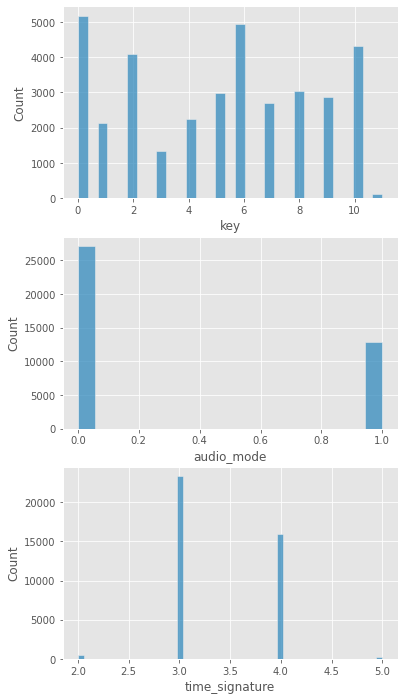

In [8]:
fig, axs = plt.subplots(len(col_cat), figsize=(6, len(col_cat)*4))

for col, ax in zip(col_cat, axs):
    sns.histplot(X[col], ax=ax)

<AxesSubplot:ylabel='Frequency'>

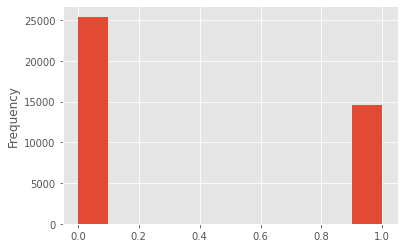

In [9]:
y.plot.hist()

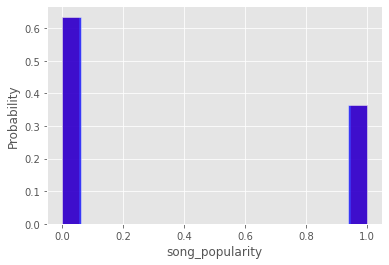

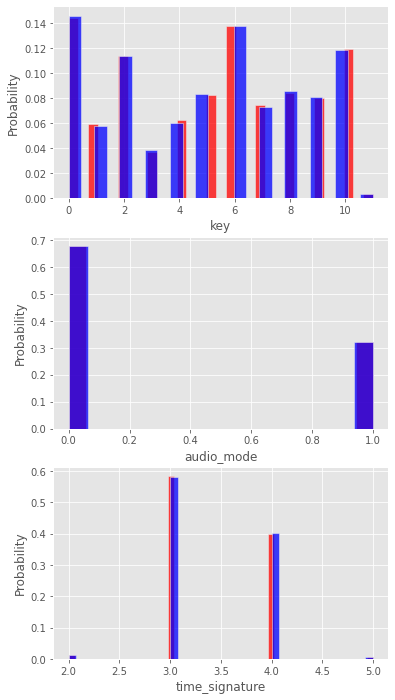

In [10]:
sns.histplot(x=y, stat='probability', color='r')
sns.histplot(x=y_clean, stat='probability', color='b')

fig, axs = plt.subplots(len(col_cat), figsize=(6, len(col_cat)*4))

for col, ax in zip(col_cat, axs):
    sns.histplot(x=X[col], ax=ax, stat='probability', color='r')
    sns.histplot(x=X_clean[col], ax=ax, stat='probability', color='b')

Same distribution for categorical and target in right to missing values.

--> So we can drop missing values for analysis if necessary.

## qq-plot

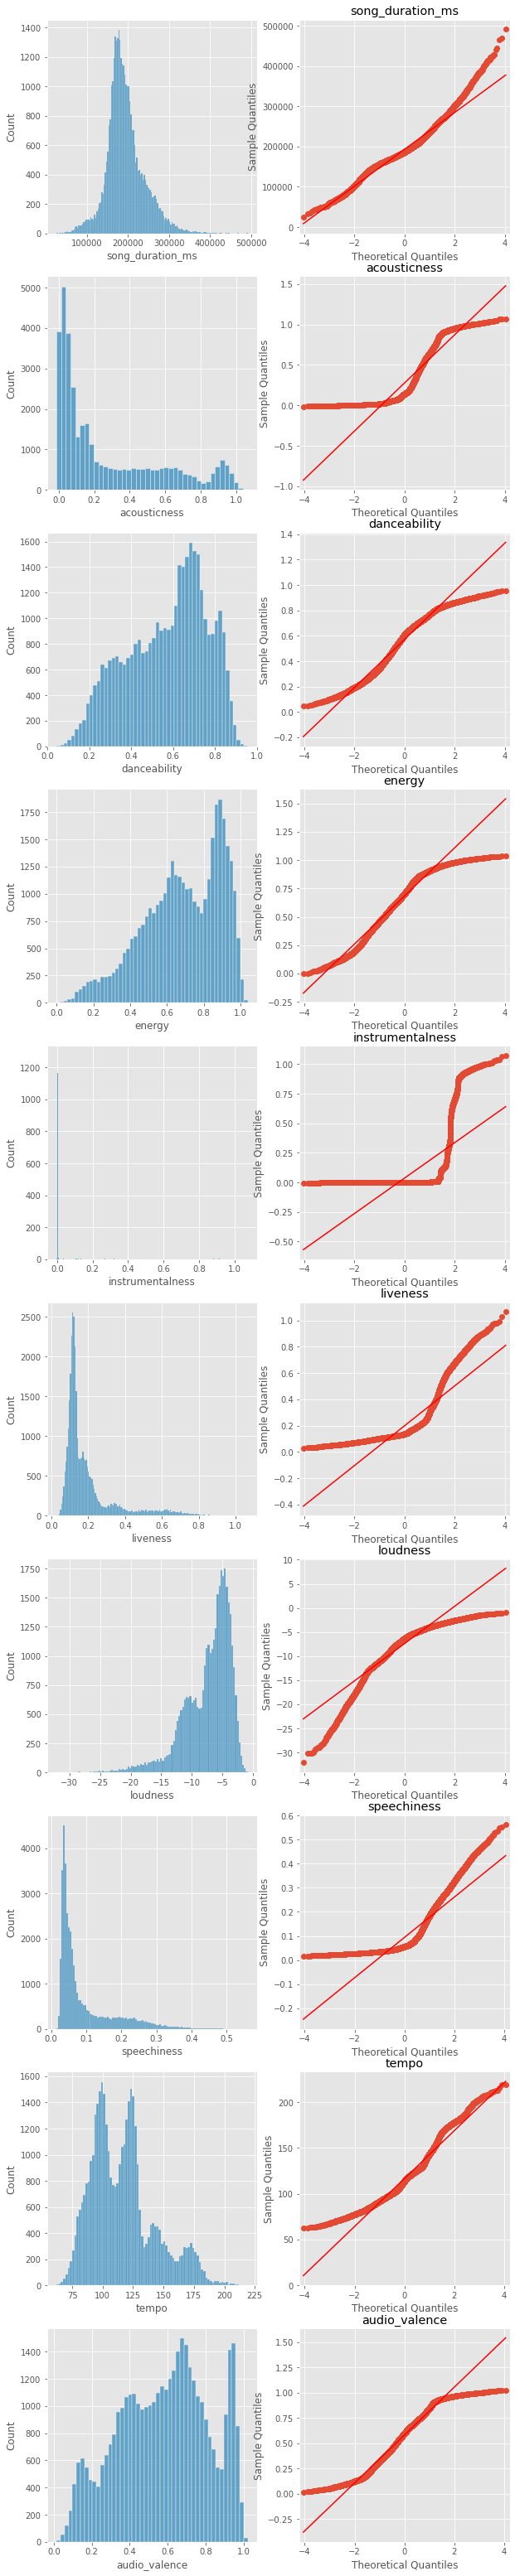

In [11]:
fig, axs = plt.subplots(len(col_num), 2,
                        figsize=(10, len(df.columns)*4))

for i, col in enumerate(col_num):
    sns.histplot(X[col], ax=axs[i, 0])
    sm.qqplot(X[col].dropna(), line="s", ax=axs[i, 1], fmt='b')
    axs[i, 1].set_title(col)

A Box-Cox transformation would be useful, especially for `loudness` and `song_duration_ms`

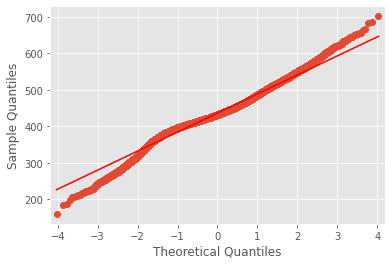

In [12]:
_ = sm.qqplot(
    X['song_duration_ms'].dropna().apply(
        lambda x: np.sqrt(x)),
    line="s", fmt='b'
)

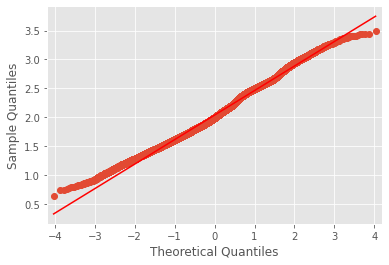

In [13]:
_ = sm.qqplot(
    X['loudness'].dropna().apply(
        lambda x: np.log1p(-x)),
    line="s", fmt='b'
)

The other columns seem to be outputs of sigmoid functions.
If we apply the inverse sigmoid we should get the logits values. Then we can box-cox transform.

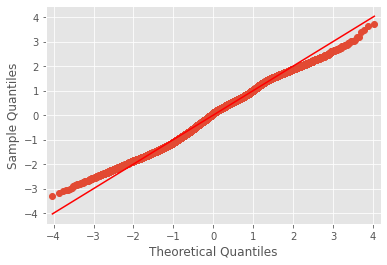

In [14]:
inv_sigmoid = lambda x: np.log(x / (1-x))

_ = sm.qqplot(
    preprocessing.power_transform(
        X[['danceability']].dropna().apply(inv_sigmoid)
    )[:, 0],
    line="s", fmt='b'
)

# <div id="FeatureEng">Feature Eng.</div>

## <div id="scaling">Processing - scaling</div>

In [15]:
col_sig = [
    'acousticness',
    'danceability',
    'energy',
    'instrumentalness',
    'liveness',
    'speechiness',
    'audio_valence',
]

col_pow = [
    'song_duration_ms',
    'tempo',
]

def scale_data(X):
    inv_sigmoid = lambda x: np.log(x / (1-x))
    
    X = X.copy()
    for col in col_sig:
        X[col] = preprocessing.minmax_scale(X[col], feature_range=(0+1e-6, 1-1e-6))
        X[col] = X[col].apply(inv_sigmoid)
    X[col_pow+col_sig] = preprocessing.power_transform(X[col_pow+col_sig])
    X['loudness'] = X['loudness'].apply(lambda x: np.log1p(-x))
    return X
    
X_proc = scale_data(X_clean)

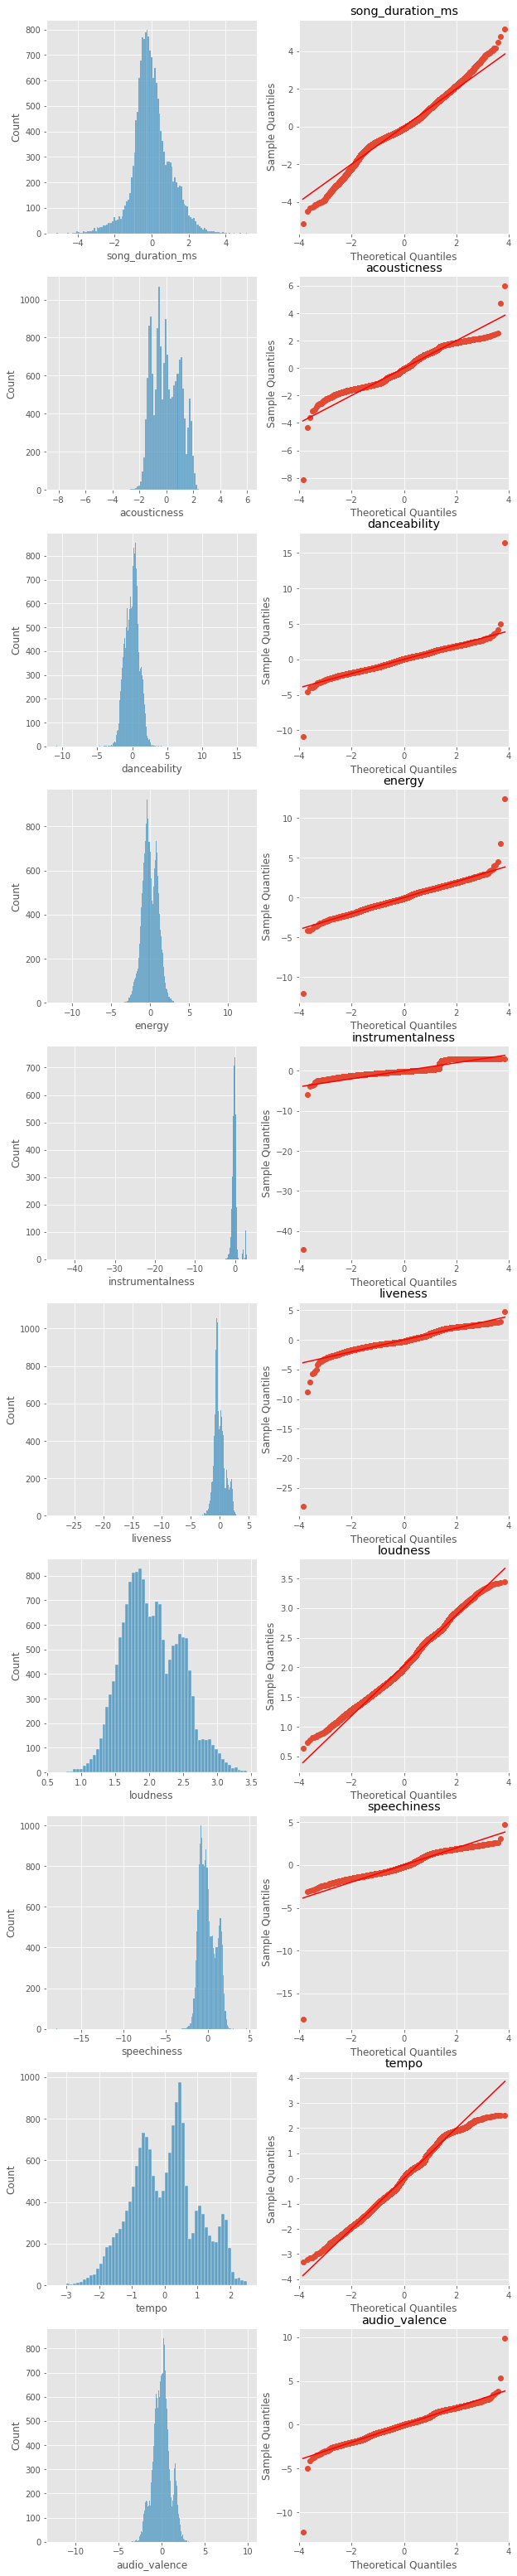

In [16]:
fig, axs = plt.subplots(len(col_num), 2,
                        figsize=(10, len(df.columns)*4))

for i, col in enumerate(col_num):
    sns.histplot(X_proc[col], ax=axs[i, 0])
    sm.qqplot(X_proc[col].dropna(), line="s", ax=axs[i, 1], fmt='b')
    axs[i, 1].set_title(col)

## PCA

In [17]:
from sklearn.decomposition import PCA

pca = PCA(random_state=random_state).fit(X_proc)

X_pca = pd.DataFrame(pca.transform(X_clean), index=X_proc.index)

pca_comp = pd.DataFrame(pca.components_, index=X.columns)
pca_comp.style.background_gradient(
    vmin=-1, vmax=1, cmap=sns.color_palette("vlag", as_cmap=True))

,0,1,2,3,4,5,6,7,8,9,10,11,12
song_duration_ms,-0.010240,0.060265,-0.039498,-0.075313,0.035841,-0.990627,-0.024604,0.032043,0.004788,-0.041277,-0.025848,-0.018637,-0.045061
acousticness,0.209428,-0.457784,0.191859,0.516131,-0.292808,-0.133063,0.148128,-0.190979,-0.016671,0.237411,0.297496,0.088724,0.358465
danceability,-0.299368,0.306400,0.616252,-0.188546,-0.231927,-0.017072,-0.055579,0.029418,0.036888,0.293112,-0.295923,-0.023106,0.409593
energy,-0.078112,-0.130591,0.081613,0.143456,0.224145,0.003905,-0.876785,-0.029249,-0.012253,-0.249335,0.088392,0.044931,0.239981
instrumentalness,0.784556,0.117249,0.095465,-0.129072,-0.363811,0.014223,-0.119132,0.013073,0.006892,-0.315072,-0.306125,-0.034116,0.061910
key,0.120041,0.030631,-0.113108,-0.119485,-0.344445,0.002566,-0.429603,0.015392,0.027733,0.658648,0.149343,-0.038552,-0.442449
liveness,-0.246293,0.283501,-0.030392,-0.109066,-0.555485,0.010918,-0.001561,0.025535,0.004849,-0.411729,0.605546,-0.015904,0.018106
loudness,-0.402644,-0.256665,-0.314701,0.235050,-0.491546,-0.009382,-0.075938,-0.066090,-0.020013,-0.163815,-0.572575,0.035929,-0.097502
audio_mode,-0.076962,-0.377834,0.657917,-0.030930,-0.003025,-0.008545,0.025941,0.000722,0.010773,-0.250511,0.015853,-0.070125,-0.590517
speechiness,0.033612,0.604980,0.131865,0.716524,0.074033,-0.008809,-0.016964,-0.108213,-0.048385,-0.020632,-0.066438,0.007350,-0.277998


## Correlation

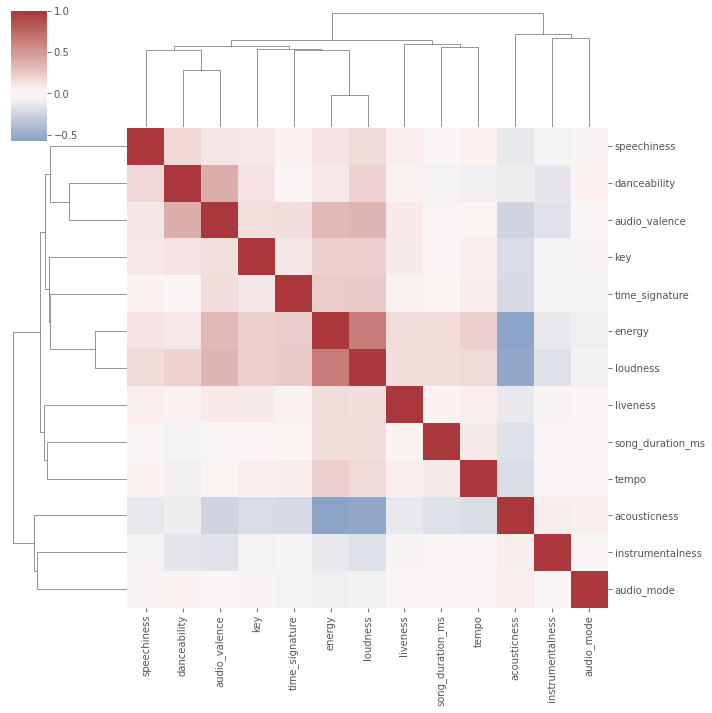

In [18]:
sns.clustermap(X_clean.corr(), center=0, cmap="vlag")

Energy and loudness are correlated

/opt/conda/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


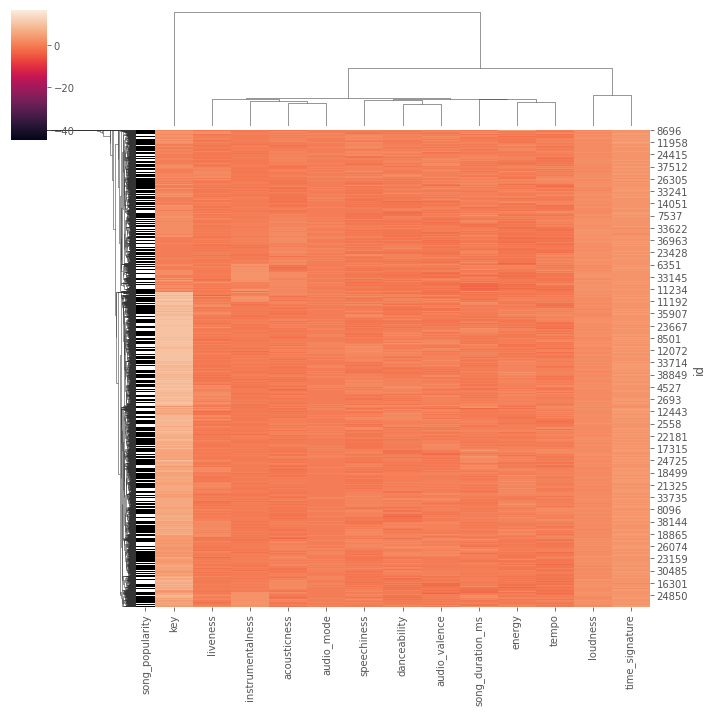

In [19]:
row_colors = dict(zip(y.unique(), 'kw'))
sns.clustermap(X_proc, row_colors=y_clean.map(row_colors))

## UMAP

With the processed data

In [20]:
from umap import UMAP
import umap.plot
from sklearn.manifold import TSNE

proj = UMAP().fit_transform(X_proc)
# proj = TSNE().fit_transform(X_proc)

<AxesSubplot:>

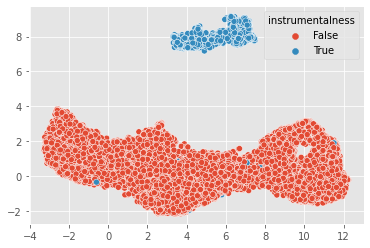

In [21]:
# umap.plot.points(mapper, labels=y_clean)
# umap.plot.points(mapper, labels=X_clean['time_signature'])

sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=X_clean['instrumentalness'] > 0.01)

The only found pattern is the same as instrumentalness > 0.01

Maybe adding this as a categorical feature could improve model performance.

# Feature importance

In [22]:
from sklearn.feature_selection import mutual_info_classif

def test_mi(X, y):
    mi = mutual_info_classif(X, y,
                             discrete_features=X.columns.isin(col_cat),
                             random_state=random_state)
    return (pd.Series(mi, index=X.columns)
            .sort_values(ascending=False)
            .to_frame()
            .style.bar())

In [23]:
test_mi(X_clean, y_clean)

,0
energy,0.006125
speechiness,0.001909
loudness,0.001680
key,0.000779
audio_valence,0.000580
time_signature,0.000274
danceability,0.000015
audio_mode,0.000000
song_duration_ms,0.000000
acousticness,0.000000


In [24]:
test_mi(X_proc, y_clean)

,0
energy,0.006223
speechiness,0.001849
loudness,0.001743
key,0.000779
audio_valence,0.000456
time_signature,0.000274
audio_mode,0.000000
song_duration_ms,0.000000
acousticness,0.000000
danceability,0.000000


# Modelling

## <div id="split">Split</div>

We will make a test fold of 10%, and 5 CV splits (20% of remaining data)

In [25]:
N_SPLITS = 5

Create a missing values table to ensure that the stratification takes into account the missing values distribution.

In [26]:
missing_ind = impute.MissingIndicator(features='missing-only')
missing_values = missing_ind.fit_transform(X)

missing_values = pd.DataFrame(missing_values, index=X.index)

1. Make stratification series (based on categorical columns, missing values, and target labels)
2. split dev and test
3. CV split of dev set

In [27]:
from sklearn.model_selection import StratifiedKFold, PredefinedSplit, train_test_split


# all categorical except `key` because it contains too many classes
# (split of less than 1 combination)
col_strat = [col_y, 'audio_mode', 'time_signature']

strat, _ = (
    df[['audio_mode', 'time_signature', col_y]]
    .join(missing_values.any(axis=1).rename('missing'))
    .astype('str')
    .apply(lambda row: '_'.join(row), axis=1)
    .factorize()
)
strat = pd.Series(strat, index=df.index)


# Split dev/test
X_dev, X_test, y_dev, y_test = train_test_split(
    X, y, test_size=0.1, random_state=random_state, shuffle=True, stratify=strat)

dev_index = X.index.isin(X_dev.index).astype(int)
test_split = PredefinedSplit(dev_index)

strat_dev = strat.loc[X_dev.index]
strat_test = strat.loc[X_test.index]


# Split train/valid
def make_folds(X, strat):
    strat_folds = StratifiedKFold(n_splits=N_SPLITS,
                                  shuffle=True,
                                  random_state=random_state)

    cv_fold = np.empty([len(X), 1], dtype=np.int32)

    for i, (_, test_index) in enumerate(strat_folds.split(X, strat)):
        cv_fold[test_index] = i

    return PredefinedSplit(cv_fold)
    
cv_split = make_folds(X_dev, strat_dev)
full_split = make_folds(X, strat)

In [28]:
# Results
[idx for idx, _ in test_split.split()], [idx for idx, _ in cv_split.split()]

([array([    0,     1,     2, ..., 39996, 39998, 39999]),
  array([    4,    16,    31, ..., 39979, 39994, 39997])],
 [array([    0,     1,     2, ..., 35997, 35998, 35999]),
  array([    0,     1,     2, ..., 35993, 35994, 35999]),
  array([    1,     2,     4, ..., 35997, 35998, 35999]),
  array([    0,     3,     4, ..., 35996, 35997, 35998]),
  array([    0,     1,     2, ..., 35997, 35998, 35999])])

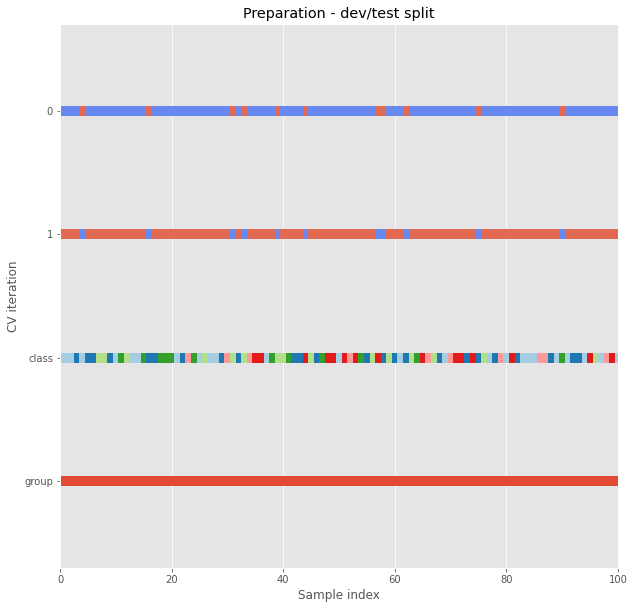

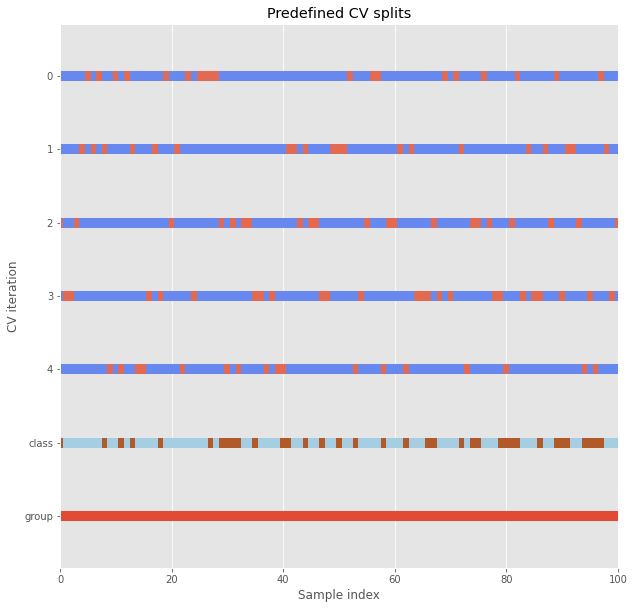

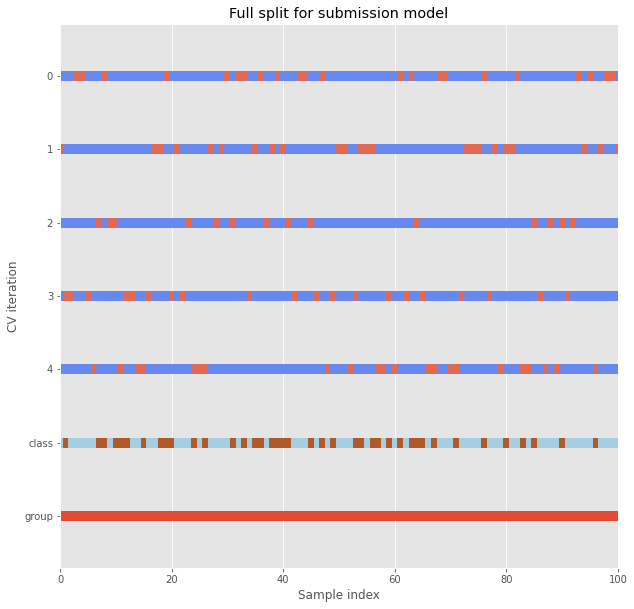

In [29]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

fig, ax = plt.subplots(figsize=(10, 10))
plot_cv_indices(test_split, X, strat, group=None, ax=ax, n_splits=2)
ax.set_title('Preparation - dev/test split')

# fig, ax = plt.subplots(figsize=(10, 10))
# plot_cv_indices(strat_folds, X_dev, strat_dev, group=None, ax=ax, n_splits=N_SPLITS)
# ax.set_title('Preparation - Stratification CV')

fig, ax = plt.subplots(figsize=(10, 10))
plot_cv_indices(cv_split, X_dev, y_dev, group=None, ax=ax, n_splits=N_SPLITS)
ax.set_title('Predefined CV splits')

fig, ax = plt.subplots(figsize=(10, 10))
plot_cv_indices(full_split, X, y, group=None, ax=ax, n_splits=N_SPLITS)
ax.set_title('Full split for submission model')

plt.show()

## <div id="sklearn">Benchmark with Pipeline (LR / GB / RF)</div>

In [30]:
col_sig = [
    'acousticness',
    'danceability',
    'energy',
    'instrumentalness',
    'liveness',
    'speechiness',
    'audio_valence',
]

col_pow = [
    'song_duration_ms',
    'tempo',
]

# For comparison between pipeline and previous processing code:

# def scale_data(X):
#     inv_sigmoid = lambda x: np.log(x / (1-x))
    
#     X = X.copy()
#     for col in col_sig:
#         X[col] = preprocessing.minmax_scale(X[col], feature_range=(0+1e-6, 1-1e-6))
#         X[col] = X[col].apply(inv_sigmoid)
#     X[col_pow+col_sig] = preprocessing.power_transform(X[col_pow+col_sig])
#     X['loudness'] = X['loudness'].apply(lambda x: np.log1p(-x))
#     return X

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.experimental import enable_hist_gradient_boosting

from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

# Model Pipeline
inv_sigmoid = Pipeline([
    ('0', preprocessing.MinMaxScaler(feature_range=(1e-3, 1-1e-3))),
    ('1', FunctionTransformer(lambda x: np.log(x / (1-x)))),
    ('2', preprocessing.PowerTransformer())
])

transformer = ColumnTransformer([
    ('inv_sigmoid', inv_sigmoid, col_sig),
    ('scale', preprocessing.PowerTransformer(), col_pow),
    ('db_to_num', FunctionTransformer(lambda x: np.log1p(-x)), ['loudness']),
], remainder='passthrough')

pipe = Pipeline([
    ('transform', transformer),
    ('imputer', impute.SimpleImputer(strategy='median')),
    ('model', LogisticRegression())
])

param_grid = [{
    'model': [LogisticRegression(),
              HistGradientBoostingClassifier(),
              ExtraTreesClassifier()],
    'imputer': [impute.SimpleImputer(strategy='median'),
                impute.SimpleImputer(strategy='mean'),
               ],#impute.KNNImputer()],
    'transform__inv_sigmoid__0': ['passthrough'],
    'transform__inv_sigmoid__1': ['passthrough'],
},{
    'model': [LogisticRegression(),
              HistGradientBoostingClassifier(),
              ExtraTreesClassifier()],
    'imputer': [impute.SimpleImputer(strategy='median'),
                impute.SimpleImputer(strategy='mean'),
                ],#impute.KNNImputer()],
},{
    'model': [HistGradientBoostingClassifier()],
    'imputer': ['passthrough', impute.IterativeImputer()],
},{
    'model': [HistGradientBoostingClassifier()],
    'imputer': ['passthrough'],
    'transform__inv_sigmoid__0': ['passthrough'],
    'transform__inv_sigmoid__1': ['passthrough'],
}]

gscv = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=['roc_auc', 'neg_log_loss'],
    n_jobs=4,
    refit='roc_auc',
    cv=cv_split,
    verbose=1,
    error_score='raise',
    return_train_score=True
)

_ = gscv.fit(X_dev, y_dev)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   40.0s
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:  1.1min finished


In [32]:
r = pd.DataFrame(gscv.cv_results_)\
    .sort_values('rank_test_roc_auc')
    #.apply(lambda x: x.abs() if np.issubdtype(x.dtype, np.number) else x)
r.filter(regex='mean|param_').style.bar(
    align='zero', vmin=-1, vmax=1, color=['#5fba7d', '#d65f5f'])

,mean_fit_time,mean_score_time,param_imputer,param_model,param_transform__inv_sigmoid__0,param_transform__inv_sigmoid__1,mean_test_roc_auc,mean_train_roc_auc,mean_test_neg_log_loss,mean_train_neg_log_loss
13,3.537426,0.173963,IterativeImputer(),HistGradientBoostingClassifier(),nan,nan,0.570291,0.690976,-0.648983,-0.620971
12,1.112007,0.083976,passthrough,HistGradientBoostingClassifier(),nan,nan,0.569094,0.693988,-0.649152,-0.621215
14,1.059176,0.071521,passthrough,HistGradientBoostingClassifier(),passthrough,passthrough,0.567179,0.697213,-0.649605,-0.619375
10,1.058366,0.082692,SimpleImputer(),HistGradientBoostingClassifier(),nan,nan,0.566184,0.681929,-0.650132,-0.623999
7,1.148941,0.084104,SimpleImputer(strategy='median'),HistGradientBoostingClassifier(),nan,nan,0.565694,0.686486,-0.649934,-0.623065
1,1.169595,0.079401,SimpleImputer(strategy='median'),HistGradientBoostingClassifier(),passthrough,passthrough,0.565001,0.685544,-0.650101,-0.623237
4,1.044545,0.081571,SimpleImputer(),HistGradientBoostingClassifier(),passthrough,passthrough,0.563015,0.687407,-0.650533,-0.622359
9,0.713548,0.048617,SimpleImputer(),LogisticRegression(),nan,nan,0.556152,0.557638,-0.651745,-0.651387
6,0.884512,0.050117,SimpleImputer(strategy='median'),LogisticRegression(),nan,nan,0.556072,0.557463,-0.651758,-0.651418
3,0.666969,0.048373,SimpleImputer(),LogisticRegression(),passthrough,passthrough,0.553806,0.555548,-0.652133,-0.651751


In [33]:
from sklearn.model_selection import cross_val_score

model = gscv.best_estimator_
model.set_params(model__max_iter=1_000)

print(f"full cv score: {cross_val_score(model, X, y, cv=full_split, scoring='roc_auc')}")
print(f"dev/test score: {cross_val_score(model, X, y, cv=test_split, scoring='roc_auc')}")

# _ = model.fit(X, y)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


full cv score: [0.56551872 0.55830535 0.57249263 0.56207019 0.56788511]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


dev/test score: [0.57282928 0.52620471]


## <div id="lgb">Optuna - LightGBM</div>

In [34]:
import optuna
import lightgbm as lgb
from optuna.integration import lightgbm as opt_lgb

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [35]:
X_lgb = transformer.fit_transform(X)

print(col_cat)
pd.DataFrame(X_lgb).describe()

['key', 'audio_mode', 'time_signature']


,0,1,2,3,4,5,6,7,8,9,10,11,12
count,3.600800e+04,3.597400e+04,3.602500e+04,3.601500e+04,3.591400e+04,4.000000e+04,4.000000e+04,3.589900e+04,4.000000e+04,36043.000000,35935.000000,40000.000000,40000.000000
mean,-1.740196e-16,-4.859502e-17,1.826899e-17,-2.053570e-16,-1.446700e-16,3.528844e-17,1.077289e-17,-1.545247e-15,-1.095765e-14,2.035981,5.042605,0.321150,3.394375
std,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000013e+00,1.000013e+00,1.000014e+00,1.000013e+00,0.424920,3.372728,0.466924,0.524405
min,-3.555094e+00,-5.907480e+00,-6.439397e+00,-9.008885e+00,-1.183625e+01,-6.335632e+00,-6.232396e+00,-5.189700e+00,-3.240767e+00,0.629859,0.000000,0.000000,2.000000
25%,-7.964261e-01,-7.327037e-01,-6.920783e-01,-5.255246e-01,-6.235546e-01,-7.947957e-01,-6.518436e-01,-5.530111e-01,-7.179448e-01,1.726458,2.000000,0.000000,3.000000
50%,-7.400099e-02,7.012358e-02,-7.702589e-02,-1.398911e-01,-2.117152e-01,-1.681777e-01,8.072691e-03,-8.721010e-02,5.490437e-02,1.994076,5.000000,0.000000,3.000000
75%,8.415159e-01,6.622560e-01,7.724986e-01,2.229977e-01,5.939315e-01,8.101147e-01,5.841900e-01,5.238762e-01,6.027732e-01,2.358790,8.000000,1.000000,4.000000
max,3.583367e+00,7.922476e+00,6.098076e+00,2.818321e+00,2.921294e+00,3.144012e+00,5.100228e+00,5.155563e+00,2.641393e+00,3.500074,11.000000,1.000000,5.000000


In [36]:
dtrain = lgb.Dataset(X_lgb, label=y, categorical_feature= [10, 11, 12],)

params = {
    "objective": "binary",
    "num_iterations": 1_000,
    "metric": "auc",
    "verbosity": -100,
    #"verbose_eval": -1,
    "boosting_type": "gbdt",
}

tuner = opt_lgb.LightGBMTunerCV(
    params,
    dtrain,
    folds=full_split,
    return_cvbooster=True,
    optuna_seed=random_state,
    #verbosity=False,
    verbose_eval=False,
    show_progress_bar=False,
    #early_stopping_rounds=100,
    callbacks=[lgb.early_stopping(100, verbose=False)], #lgb.log_evaluation(0)],
)
tuner.run()

lgb_boosters = tuner.get_best_booster().boosters

print("Best score:", tuner.best_score)
print('Best iteration:', tuner.get_best_booster().best_iteration)
tuner.best_params

[I 2022-02-02 13:02:14,732] A new study created in memory with name: no-name-57be8844-bb3f-4950-a148-1ca820521b07
[I 2022-02-02 13:02:17,271] Trial 0 finished with value: 0.5688544137600433 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.5688544137600433.
[I 2022-02-02 13:02:19,581] Trial 1 finished with value: 0.5692376865426818 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.5692376865426818.
[I 2022-02-02 13:02:22,550] Trial 2 finished with value: 0.5648485366183784 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.5692376865426818.
[I 2022-02-02 13:02:25,803] Trial 3 finished with value: 0.5684280774827315 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.5692376865426818.
[I 2022-02-02 13:02:28,152] Trial 4 finished with value: 0.5706001067125429 and parameters: {'feature_fraction': 0.6}. Best is trial 4 with value: 0.5706001067125429.
[I 2022-02-02 13:02:31,539] Trial 5 finished with v

Best score: 0.576903085356981
Best iteration: 385


{'objective': 'binary',
 'num_iterations': 1000,
 'metric': 'auc',
 'verbosity': -100,
 'boosting_type': 'gbdt',
 'feature_pre_filter': False,
 'lambda_l1': 5.045896527823807e-05,
 'lambda_l2': 2.5658581133290594,
 'num_leaves': 3,
 'feature_fraction': 0.6,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

In [37]:
dtrain_raw = lgb.Dataset(X, label=y, categorical_feature=col_cat)

params = {
    "objective": "binary",
    "num_iterations": 1_000,
    "metric": "auc",
    "verbosity": -100,
    #"verbose_eval": -1,
    "boosting_type": "gbdt",
}

tuner_raw = opt_lgb.LightGBMTunerCV(
    params,
    dtrain_raw,
    folds=full_split,
    return_cvbooster=True,
    optuna_seed=random_state,
    #verbosity=False,
    verbose_eval=False,
    show_progress_bar=False,
    #early_stopping_rounds=100,
    callbacks=[lgb.early_stopping(100, verbose=False)], #lgb.log_evaluation(0)],
)
tuner_raw.run()

lgb_boosters_raw = tuner_raw.get_best_booster().boosters

print("Best score:", tuner_raw.best_score)
print('Best iteration:', tuner_raw.get_best_booster().best_iteration)
tuner_raw.best_params

[I 2022-02-02 13:07:14,319] A new study created in memory with name: no-name-5fea9b2a-adce-4e17-b311-49e865066259
[I 2022-02-02 13:07:16,864] Trial 0 finished with value: 0.5666492801746228 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.5666492801746228.
[I 2022-02-02 13:07:20,082] Trial 1 finished with value: 0.5700911878642838 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.5700911878642838.
[I 2022-02-02 13:07:22,362] Trial 2 finished with value: 0.5709227243409478 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 0.5709227243409478.
[I 2022-02-02 13:07:25,344] Trial 3 finished with value: 0.5674555528725439 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 2 with value: 0.5709227243409478.
[I 2022-02-02 13:07:27,717] Trial 4 finished with value: 0.5692583251460833 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 0.5709227243409478.
[I 2022-02-02 13:07:30,634] Trial 5 

Best score: 0.5768643831608192
Best iteration: 421


{'objective': 'binary',
 'num_iterations': 1000,
 'metric': 'auc',
 'verbosity': -100,
 'boosting_type': 'gbdt',
 'feature_pre_filter': False,
 'lambda_l1': 5.319049072944658,
 'lambda_l2': 0.13167856913788833,
 'num_leaves': 3,
 'feature_fraction': 0.4,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

**/!\ added solution after the competition end /!\**

In [38]:
inv_sigmoid2 = Pipeline([
    ('0', preprocessing.MinMaxScaler(feature_range=(1e-3, 1-1e-3))),
    ('1', FunctionTransformer(lambda x: np.log(x / (1-x)))),
])

transformer2 = ColumnTransformer([
    ('inv_sigmoid', inv_sigmoid2, col_sig),
    #('scale', preprocessing.PowerTransformer(), col_pow),
    ('db_to_num', FunctionTransformer(lambda x: np.log1p(-x)), ['loudness']),
], remainder='passthrough')

X_lgb2 = transformer2.fit_transform(X)

dtrain2 = lgb.Dataset(X_lgb2, label=y, categorical_feature= [10, 11, 12],)

params = {
    "objective": "binary",
    "num_iterations": 1_000,
    "metric": "auc",
    "verbosity": -100,
    #"verbose_eval": -1,
    "boosting_type": "gbdt",
}

tuner2 = opt_lgb.LightGBMTunerCV(
    params,
    dtrain2,
    folds=full_split,
    return_cvbooster=True,
    optuna_seed=random_state,
    #verbosity=False,
    verbose_eval=False,
    show_progress_bar=False,
    #early_stopping_rounds=100,
    callbacks=[lgb.early_stopping(100, verbose=False)], #lgb.log_evaluation(0)],
)
tuner2.run()

lgb_boosters2 = tuner2.get_best_booster().boosters

print("Best score:", tuner.best_score)
print('Best iteration:', tuner.get_best_booster().best_iteration)
tuner2.best_params

[I 2022-02-02 13:12:15,873] A new study created in memory with name: no-name-fea7987d-1b73-466e-82c8-bd81ec71e80e
[I 2022-02-02 13:12:18,463] Trial 0 finished with value: 0.5589236230561172 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.5589236230561172.
[I 2022-02-02 13:12:21,203] Trial 1 finished with value: 0.5559458049197575 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.5589236230561172.
[I 2022-02-02 13:12:24,040] Trial 2 finished with value: 0.5552057391271874 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.5589236230561172.
[I 2022-02-02 13:12:27,171] Trial 3 finished with value: 0.5513265675046359 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.5589236230561172.
[I 2022-02-02 13:12:30,123] Trial 4 finished with value: 0.5534796110256328 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.5589236230561172.
[I 2022-02-02 13:12:31,967] Trial 5 

Best score: 0.576903085356981
Best iteration: 385


{'objective': 'binary',
 'num_iterations': 1000,
 'metric': 'auc',
 'verbosity': -100,
 'boosting_type': 'gbdt',
 'feature_pre_filter': False,
 'lambda_l1': 5.402896923508629,
 'lambda_l2': 0.00018194741639177489,
 'num_leaves': 16,
 'feature_fraction': 0.4,
 'bagging_fraction': 0.6591670111857015,
 'bagging_freq': 3,
 'min_child_samples': 5}

# Submission

In [39]:
df_sample['song_popularity'] = model.predict(df_sub)

df_sample.to_csv('submission_sklearn.csv')

In [40]:
df_sub_proc = transformer.transform(df_sub)
y_sub = np.stack([m.predict(df_sub_proc) for m in lgb_boosters], axis=1)
df_sample['song_popularity'] = np.mean(y_sub, axis=1)

df_sample.to_csv('submission_lgb.csv')

In [41]:
y_sub = np.stack([m.predict(df_sub) for m in lgb_boosters_raw], axis=1)
df_sample['song_popularity'] = np.mean(y_sub, axis=1)

df_sample.to_csv('submission_lgb_raw.csv')

**/!\ added solution after the competition end /!\**

In [42]:
df_sub_proc = transformer2.transform(df_sub)
y_sub = np.stack([m.predict(df_sub_proc) for m in lgb_boosters2], axis=1)
df_sample['song_popularity'] = np.mean(y_sub, axis=1)

df_sample.to_csv('submission_lgb2.csv')

# Stacking - Blending

In [43]:
from sklearn.model_selection import cross_val_predict

def get_oob(ys, cv):
    y = ys[0]
    for i, (_, test_idx) in enumerate(cv.split()):
        y[test_idx] = ys[i][test_idx]
    return y
    
X_proc = transformer.fit_transform(X)
X_proc_test = transformer.transform(df_sub)

X_stack_train = [
    cross_val_predict(model, X, y, cv=full_split,
                      method='predict_proba')[:, 1],
    get_oob([m.predict(X_proc) for m in lgb_boosters], full_split),
    get_oob([m.predict(X) for m in lgb_boosters_raw], full_split)
]
X_stack_train = np.stack(X_stack_train, axis=1)

stack_model = LogisticRegression().fit(X_stack_train, y)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


In [44]:
X_stack_test = [
    model.predict_proba(df_sub)[:, 1],
    np.mean([m.predict(X_proc_test) for m in lgb_boosters], axis=0),
    np.mean([m.predict(df_sub) for m in lgb_boosters_raw], axis=0),
]
X_stack_test = np.stack(X_stack_test, axis=1)

In [45]:
y_pred = stack_model.predict(X_stack_test)

df_sample['song_popularity'] = y_pred
df_sample.to_csv('submission_stack.csv')

In [46]:
cross_val_score(stack_model, X_stack_train, y, scoring='roc_auc')

array([0.57723679, 0.57369528, 0.57601144, 0.57706158, 0.58068165])